In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
os.chdir("/content/gdrive/My Drive/Studies/tweets/")

In [3]:
pip install transformers sentencepiece imblearn --quiet

In [4]:
import gc
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from tensorflow.keras import layers, backend as K
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import (
    f1_score, roc_auc_score, confusion_matrix,
    accuracy_score, classification_report
)

from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler

import transformers as tr
from transformers import TFAutoModel, AutoTokenizer
from transformers.modeling_tf_utils import TFSequenceClassificationLoss

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from s

In [5]:
tf.get_logger().setLevel('ERROR')
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print(f"{'='*80}\nREPLICAS: {strategy.num_replicas_in_sync}\n{'='*80}")

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


Running on TPU  grpc://10.17.49.242:8470
REPLICAS: 8


In [6]:
class Camembert(tr.TFRobertaPreTrainedModel, TFSequenceClassificationLoss):
    """
    Classic classifier w/ transformer layer: Camembert
    Using CLS token representation
    Output: array of (batch_size, num_labels)
    """
    config_class = tr.CamembertConfig
    _keys_to_ignore_on_load_missing = [r"pooler", r"lm_head"]
    
    def __init__(self, config, *inputs, **kwargs):
        super().__init__(config, *inputs, **kwargs)
        self.camembert = tr.TFRobertaMainLayer(
            config,
            name = "ro_camembert")
        self.stride = layers.Lambda(lambda x: x[:, 0, :], name = "stride")
        self.classifier = layers.Dense(
            4,
            activation = tf.keras.activations.softmax,
            name = "classifier")
    
    def call(self, inputs = None, **kwargs):
        outputs = self.camembert(inputs, **kwargs)
        sequences = outputs[0]
        cls_token = self.stride(sequences)
        return self.classifier(cls_token)

In [7]:
class Save(Callback):
  def __init__(self, path = "./", monitor = 'loss'):
    super(Save, self).__init__()
    self.path = path
    self.monitor = monitor

  def on_epoch_end(self, epoch, logs = None):
    path = f"{self.path}{epoch}-{logs[self.monitor]}"
    self.model.save_pretrained(path)

# Modèle sans prétraitement
Uniquement les URLs

In [8]:
train = pd.read_pickle('datasets/train_basic.pkl')
val = pd.read_pickle('datasets/val_basic.pkl')
test = pd.read_pickle('datasets/test_basic.pkl')

In [9]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16*strategy.num_replicas_in_sync
BATCH_D = BATCH_SIZE
MAX_LEN = 26
N_LABELS = 4
BUFFER = 300000
SEED = 42069
MODEL = "cam_base"
NTRAIN = train.shape[0]
NVAL = val.shape[0]
STEPS = int(np.ceil(NTRAIN/BATCH_D))
VAL_STEPS = int(np.ceil(NVAL/BATCH_D))

print("Total Steps:", STEPS)
print("Total Validation Steps:", VAL_STEPS)

Total Steps: 40
Total Validation Steps: 10


In [10]:
tr.set_seed(SEED)

In [11]:
with strategy.scope():
  model = Camembert.from_pretrained(f"weights/{MODEL}")
  tokenizer = AutoTokenizer.from_pretrained(f"weights/{MODEL}")

  save = Save(path = f"weights/{MODEL}/epochs/", monitor = "val_loss")
  early = tf.keras.callbacks.EarlyStopping(
      monitor = 'val_loss',
      patience = 2,
      restore_best_weights = True
  )
  callbacks = [save, early]
  

All model checkpoint layers were used when initializing Camembert.

All the layers of Camembert were initialized from the model checkpoint at weights/cam_base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use Camembert for predictions without further training.


In [12]:
with strategy.scope():
  model.layers[0].trainable = False
  optimizer = tf.keras.optimizers.Adam(lr=1e-5)
  model.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
encoder = LabelEncoder()

In [14]:
x_train = tokenizer.batch_encode_plus(
  train.tweet.to_list(), truncation=True, 
  return_tensors='tf', max_length=MAX_LEN,
  return_attention_mask = False,
  padding = "max_length")['input_ids']

x_val = tokenizer.batch_encode_plus(
  val.tweet.to_list(), truncation=True, 
  return_tensors='tf', max_length=MAX_LEN,
  return_attention_mask = False,
  padding = "max_length")['input_ids']

x_test = tokenizer.batch_encode_plus(
  test.tweet.to_list(), truncation=True, 
  return_tensors='tf', max_length=MAX_LEN,
  return_attention_mask = False,
  padding = "max_length")['input_ids']

y_train = encoder.fit_transform(train.label)
y_val = encoder.transform(val.label)
y_test = encoder.transform(test.label)

In [15]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(BUFFER)
    .batch(BATCH_D)
    .prefetch(AUTO)
)

val_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_val, y_val))
    .batch(BATCH_D)
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_D)
)

## Entraînement du modèle

In [16]:
epochs_done = 0
history = model.fit(
  train_dataset,
  epochs = 200,
  steps_per_epoch = STEPS,
  callbacks = [early],
  validation_data = val_dataset,
  initial_epoch = epochs_done,
  workers = 8,
  use_multiprocessing = True
)

Epoch 1/200
40/40 [==============================] - 28s 196ms/step - loss: 3.0774 - accuracy: 0.0130 - val_loss: 3.0072 - val_accuracy: 0.0117
Epoch 2/200
40/40 [==============================] - 2s 50ms/step - loss: 2.7675 - accuracy: 0.0156 - val_loss: 2.6517 - val_accuracy: 0.0117
Epoch 3/200
40/40 [==============================] - 2s 50ms/step - loss: 2.4744 - accuracy: 0.0273 - val_loss: 2.3334 - val_accuracy: 0.0117
Epoch 4/200
40/40 [==============================] - 2s 51ms/step - loss: 2.2068 - accuracy: 0.0296 - val_loss: 2.0647 - val_accuracy: 0.0117
Epoch 5/200
40/40 [==============================] - 2s 52ms/step - loss: 2.0042 - accuracy: 0.0518 - val_loss: 1.8430 - val_accuracy: 0.0117
Epoch 6/200
40/40 [==============================] - 2s 51ms/step - loss: 1.8198 - accuracy: 0.1018 - val_loss: 1.6631 - val_accuracy: 0.0117
Epoch 7/200
40/40 [==============================] - 2s 63ms/step - loss: 1.7074 - accuracy: 0.1513 - val_loss: 1.5225 - val_accuracy: 0.0180
Epoc

In [17]:
with strategy.scope():
  model.layers[0].trainable = True
  optimizer = tf.keras.optimizers.Adam(lr=1e-7)
  model.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
epochs_done = 42
history = model.fit(
  train_dataset,
  epochs = 200,
  steps_per_epoch = STEPS,
  callbacks = [early],
  validation_data = val_dataset,
  initial_epoch = epochs_done,
  workers = 8,
  use_multiprocessing = True
)

Epoch 43/200
40/40 [==============================] - 73s 254ms/step - loss: 1.0975 - accuracy: 0.4689 - val_loss: 1.0151 - val_accuracy: 0.5297
Epoch 44/200
40/40 [==============================] - 4s 100ms/step - loss: 1.1267 - accuracy: 0.4699 - val_loss: 1.0102 - val_accuracy: 0.5312
Epoch 45/200
40/40 [==============================] - 4s 100ms/step - loss: 1.0906 - accuracy: 0.4769 - val_loss: 1.0142 - val_accuracy: 0.5305
Epoch 46/200
40/40 [==============================] - 4s 101ms/step - loss: 1.0684 - accuracy: 0.5024 - val_loss: 1.0170 - val_accuracy: 0.5297


In [19]:
model.save_pretrained(f"weights/{MODEL}/nopreproc")

## Evaluation du modèle

In [20]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((
        tf.concat([x_train, x_val], axis = 0),
        np.concatenate([y_train, y_val])
      ))
    .repeat()
    .shuffle(BUFFER)
    .batch(BATCH_D)
    .prefetch(AUTO)
)

In [21]:
with strategy.scope():
  final_model_1 = Camembert.from_pretrained(f"weights/{MODEL}")
  final_model_1.layers[0].trainable = False
  optimizer = tf.keras.optimizers.Adam(lr=1e-5)
  final_model_1.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

epochs_done = 0
history = final_model_1.fit(
  train_dataset,
  epochs = 42,
  steps_per_epoch = STEPS,
  initial_epoch = epochs_done,
  workers = 8, verbose = 0,
  use_multiprocessing = True
)

with strategy.scope():
  final_model_1.layers[0].trainable = True
  optimizer = tf.keras.optimizers.Adam(lr=1e-7)
  final_model_1.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

epochs_done = 42
history = final_model_1.fit(
  train_dataset,
  epochs = epochs_done + 4,
  steps_per_epoch = STEPS,
  initial_epoch = epochs_done,
  workers = 8, verbose = 0,
  use_multiprocessing = True
)

All model checkpoint layers were used when initializing Camembert.

All the layers of Camembert were initialized from the model checkpoint at weights/cam_base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use Camembert for predictions without further training.


In [22]:
pred_1 = final_model_1.predict(x_test)
y_1 = encoder.inverse_transform(np.argmax(pred_1, axis = 1))

In [23]:
binarizer = LabelBinarizer()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     EMOTION       0.00      0.00      0.00       337
 INFORMATION       0.45      0.98      0.62      1473
     OPINION       0.29      0.03      0.05       950
   SENTIMENT       0.00      0.00      0.00       523

    accuracy                           0.45      3283
   macro avg       0.19      0.25      0.17      3283
weighted avg       0.29      0.45      0.29      3283

F1-score: 0.16691491641663095
AUC: 0.556569793051824
Accuracy: 0.4468473956746878


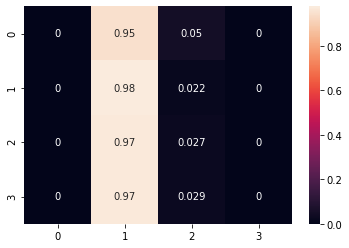

In [24]:
print(classification_report(test.label, y_1))

print("F1-score: {}\nAUC: {}\nAccuracy: {}".format(
    f1_score(test.label, y_1, average = "macro"),
    roc_auc_score(binarizer.fit_transform(y_test), pred_1, average = "macro", multi_class = "ovr"),
    accuracy_score(test.label, y_1)
))

sns.heatmap(
    confusion_matrix(test.label, y_1, normalize='true'),
    annot = True
)

# Modèle sans prétraitement avec sur-échantillonnage

## Entraînement

Sur-échantillonnage

In [25]:
ros = RandomOverSampler(
    sampling_strategy={
        0: 1746,
        1: 2707,
        2: 1746,
        3: 1746
    }
)
x_ros, y_ros = ros.fit_resample(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [26]:
with strategy.scope():
  model_2 = Camembert.from_pretrained(f"weights/{MODEL}")
  model_2.layers[0].trainable = False
  optimizer = tf.keras.optimizers.Adam(lr=1e-5)
  model_2.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  train_ros_dataset = (
      tf.data.Dataset
      .from_tensor_slices((x_ros, y_ros))
      .repeat()
      .shuffle(BUFFER)
      .batch(BATCH_D)
      .prefetch(AUTO)
  )

epochs_done = 0
history = model_2.fit(
  train_ros_dataset,
  epochs = 200,
  steps_per_epoch = int(np.ceil(x_ros.shape[0]/BATCH_D)),
  callbacks = [early],
  validation_data = val_dataset,
  initial_epoch = epochs_done,
  workers = 8,
  use_multiprocessing = True
)

All model checkpoint layers were used when initializing Camembert.

All the layers of Camembert were initialized from the model checkpoint at weights/cam_base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use Camembert for predictions without further training.


Epoch 1/200
63/63 [==============================] - 27s 132ms/step - loss: 2.3550 - accuracy: 0.2172 - val_loss: 2.8032 - val_accuracy: 0.0117
Epoch 2/200
63/63 [==============================] - 3s 40ms/step - loss: 2.0519 - accuracy: 0.2019 - val_loss: 2.3283 - val_accuracy: 0.0117
Epoch 3/200
63/63 [==============================] - 3s 41ms/step - loss: 1.8314 - accuracy: 0.2062 - val_loss: 1.9829 - val_accuracy: 0.0117
Epoch 4/200
63/63 [==============================] - 3s 41ms/step - loss: 1.6656 - accuracy: 0.2262 - val_loss: 1.7412 - val_accuracy: 0.0117
Epoch 5/200
63/63 [==============================] - 3s 41ms/step - loss: 1.6098 - accuracy: 0.2204 - val_loss: 1.5724 - val_accuracy: 0.0125
Epoch 6/200
63/63 [==============================] - 3s 42ms/step - loss: 1.5373 - accuracy: 0.2537 - val_loss: 1.4679 - val_accuracy: 0.0672
Epoch 7/200
63/63 [==============================] - 3s 42ms/step - loss: 1.5309 - accuracy: 0.2450 - val_loss: 1.3896 - val_accuracy: 0.2609
Epoc

In [27]:
with strategy.scope():
  model_2.layers[0].trainable = True
  optimizer = tf.keras.optimizers.Adam(lr=1e-7)
  model.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

epochs_done = 16
history = model_2.fit(
  train_ros_dataset,
  epochs = 200,
  steps_per_epoch = int(np.ceil(x_ros.shape[0]/BATCH_D)),
  callbacks = [early],
  validation_data = val_dataset,
  initial_epoch = epochs_done,
  workers = 8,
  use_multiprocessing = True
)

Epoch 17/200
63/63 [==============================] - 3s 43ms/step - loss: 1.5060 - accuracy: 0.2724 - val_loss: 1.2761 - val_accuracy: 0.5281
Epoch 18/200
63/63 [==============================] - 3s 43ms/step - loss: 1.4926 - accuracy: 0.2819 - val_loss: 1.2721 - val_accuracy: 0.5273
Epoch 19/200
63/63 [==============================] - 3s 41ms/step - loss: 1.4851 - accuracy: 0.2862 - val_loss: 1.2875 - val_accuracy: 0.5242
Epoch 20/200
63/63 [==============================] - 3s 41ms/step - loss: 1.4966 - accuracy: 0.2790 - val_loss: 1.2819 - val_accuracy: 0.5234


## Evaluation

In [28]:
counts = np.sort(np.unique(np.concatenate([y_train, y_val]), return_counts = True)[1])
ros = RandomOverSampler(sampling_strategy={
    0: counts[-2],
    1: counts[-1],
    2: counts[-2],
    3: counts[-2]
})

x_ros, y_ros = ros.fit_resample(
    tf.concat([x_train, x_val], axis = 0),
    np.concatenate([y_train, y_val])
)

train_ros_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_ros, y_ros))
    .repeat()
    .shuffle(BUFFER)
    .batch(BATCH_D)
    .prefetch(AUTO)
)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [29]:
with strategy.scope():
  final_model_2 = Camembert.from_pretrained(f"weights/{MODEL}")
  final_model_2.layers[0].trainable = False
  optimizer = tf.keras.optimizers.Adam(lr=1e-5)
  final_model_2.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

epochs_done = 0
history = final_model_2.fit(
  train_ros_dataset,
  epochs = 14,
  steps_per_epoch = int(np.ceil(x_ros.shape[0]/BATCH_D)),
  initial_epoch = epochs_done,
  workers = 8, verbose = 0,
  use_multiprocessing = True
)

with strategy.scope():
  final_model_2.layers[0].trainable = True
  optimizer = tf.keras.optimizers.Adam(lr=1e-7)
  final_model_2.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

epochs_done = 14
history = final_model_2.fit(
  train_ros_dataset,
  epochs = epochs_done + 2,
  steps_per_epoch = int(np.ceil(x_ros.shape[0]/BATCH_D)),
  initial_epoch = epochs_done,
  workers = 8, verbose = 0,
  use_multiprocessing = True
)

All model checkpoint layers were used when initializing Camembert.

All the layers of Camembert were initialized from the model checkpoint at weights/cam_base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use Camembert for predictions without further training.


              precision    recall  f1-score   support

     EMOTION       0.14      0.02      0.03       337
 INFORMATION       0.45      0.98      0.62      1473
     OPINION       0.24      0.00      0.01       950
   SENTIMENT       0.19      0.01      0.02       523

    accuracy                           0.44      3283
   macro avg       0.25      0.25      0.17      3283
weighted avg       0.32      0.44      0.29      3283

F1-score: 0.16961180650050448
AUC: 0.5760699559595379
Accuracy: 0.44319220225403594


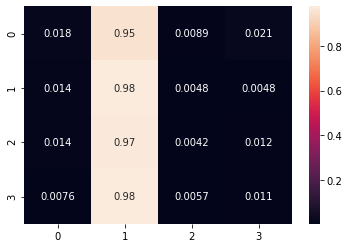

In [30]:
pred_2 = final_model_2.predict(x_test)
y_2 = encoder.inverse_transform(np.argmax(pred_2, axis = 1))

print(classification_report(test.label, y_2))

print("F1-score: {}\nAUC: {}\nAccuracy: {}".format(
    f1_score(test.label, y_2, average = "macro"),
    roc_auc_score(binarizer.fit_transform(y_test), pred_2, average = "macro", multi_class = "ovr"),
    accuracy_score(test.label, y_2)
))

sns.heatmap(
    confusion_matrix(test.label, y_2, normalize='true'),
    annot = True
)

# Modèle avec prétraitement mais sans Lem-Stem
Données classic_nos_nol

In [31]:
train = pd.read_pickle('datasets/train_classic_nos_nol.pkl')
val = pd.read_pickle('datasets/val_classic_nos_nol.pkl')
test = pd.read_pickle('datasets/test_classic_nos_nol.pkl')

In [32]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16*strategy.num_replicas_in_sync
BATCH_D = BATCH_SIZE
MAX_LEN = 26
N_LABELS = 4
BUFFER = 300000
SEED = 42069
MODEL = "cam_base"
NTRAIN = train.shape[0]
NVAL = val.shape[0]
STEPS = int(np.ceil(NTRAIN/BATCH_D))
VAL_STEPS = int(np.ceil(NVAL/BATCH_D))

print("Total Steps:", STEPS)
print("Total Validation Steps:", VAL_STEPS)

Total Steps: 40
Total Validation Steps: 10


In [33]:
with strategy.scope():
  model_3 = Camembert.from_pretrained(f"weights/{MODEL}")
  tokenizer = AutoTokenizer.from_pretrained(f"weights/{MODEL}")

  save = Save(path = f"weights/{MODEL}/epochs/", monitor = "val_loss")
  early = tf.keras.callbacks.EarlyStopping(
      monitor = 'val_loss',
      patience = 2,
      restore_best_weights = True
  )
  callbacks = [save, early]
  

All model checkpoint layers were used when initializing Camembert.

All the layers of Camembert were initialized from the model checkpoint at weights/cam_base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use Camembert for predictions without further training.


In [34]:
with strategy.scope():
  model_3.layers[0].trainable = False
  optimizer = tf.keras.optimizers.Adam(lr=1e-5)
  model_3.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [35]:
x_train = tokenizer.batch_encode_plus(
  train.tweet.to_list(), truncation=True, 
  return_tensors='tf', max_length=MAX_LEN,
  return_attention_mask = False,
  padding = "max_length")['input_ids']

x_val = tokenizer.batch_encode_plus(
  val.tweet.to_list(), truncation=True, 
  return_tensors='tf', max_length=MAX_LEN,
  return_attention_mask = False,
  padding = "max_length")['input_ids']

x_test = tokenizer.batch_encode_plus(
  test.tweet.to_list(), truncation=True, 
  return_tensors='tf', max_length=MAX_LEN,
  return_attention_mask = False,
  padding = "max_length")['input_ids']

y_train = encoder.fit_transform(train.label)
y_val = encoder.transform(val.label)
y_test = encoder.transform(test.label)

In [36]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(BUFFER)
    .batch(BATCH_D)
    .prefetch(AUTO)
)

val_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_val, y_val))
    .batch(BATCH_D)
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_D)
)

## Entraînement du modèle

In [37]:
epochs_done = 0
history = model_3.fit(
  train_dataset,
  epochs = 200,
  steps_per_epoch = STEPS,
  callbacks = [early],
  validation_data = val_dataset,
  initial_epoch = epochs_done,
  workers = 8,
  use_multiprocessing = True
)

Epoch 1/200
40/40 [==============================] - 25s 196ms/step - loss: 3.1365 - accuracy: 0.0121 - val_loss: 3.0849 - val_accuracy: 0.0117
Epoch 2/200
40/40 [==============================] - 2s 52ms/step - loss: 2.8501 - accuracy: 0.0132 - val_loss: 2.7224 - val_accuracy: 0.0117
Epoch 3/200
40/40 [==============================] - 2s 54ms/step - loss: 2.4882 - accuracy: 0.0212 - val_loss: 2.3979 - val_accuracy: 0.0117
Epoch 4/200
40/40 [==============================] - 2s 53ms/step - loss: 2.2791 - accuracy: 0.0295 - val_loss: 2.1221 - val_accuracy: 0.0117
Epoch 5/200
40/40 [==============================] - 2s 51ms/step - loss: 2.0670 - accuracy: 0.0557 - val_loss: 1.8888 - val_accuracy: 0.0117
Epoch 6/200
40/40 [==============================] - 2s 51ms/step - loss: 1.8647 - accuracy: 0.0895 - val_loss: 1.6993 - val_accuracy: 0.0117
Epoch 7/200
40/40 [==============================] - 2s 53ms/step - loss: 1.7000 - accuracy: 0.1464 - val_loss: 1.5528 - val_accuracy: 0.0133
Epoc

In [38]:
with strategy.scope():
  model_3.layers[0].trainable = True
  optimizer = tf.keras.optimizers.Adam(lr=1e-7)
  model_3.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [39]:
epochs_done = 40
history = model_3.fit(
  train_dataset,
  epochs = 200,
  steps_per_epoch = STEPS,
  callbacks = [early],
  validation_data = val_dataset,
  initial_epoch = epochs_done,
  workers = 8,
  use_multiprocessing = True
)

Epoch 41/200
40/40 [==============================] - 77s 242ms/step - loss: 1.1093 - accuracy: 0.4798 - val_loss: 1.0229 - val_accuracy: 0.5273
Epoch 42/200
40/40 [==============================] - 4s 100ms/step - loss: 1.0965 - accuracy: 0.4831 - val_loss: 1.0205 - val_accuracy: 0.5266
Epoch 43/200
40/40 [==============================] - 4s 100ms/step - loss: 1.1030 - accuracy: 0.4745 - val_loss: 1.0169 - val_accuracy: 0.5273
Epoch 44/200
40/40 [==============================] - 4s 102ms/step - loss: 1.1059 - accuracy: 0.4699 - val_loss: 1.0168 - val_accuracy: 0.5281
Epoch 45/200
40/40 [==============================] - 4s 101ms/step - loss: 1.1202 - accuracy: 0.4640 - val_loss: 1.0296 - val_accuracy: 0.5289
Epoch 46/200
40/40 [==============================] - 4s 100ms/step - loss: 1.0938 - accuracy: 0.4913 - val_loss: 1.0202 - val_accuracy: 0.5273


In [40]:
model_3.save_pretrained(f"weights/{MODEL}/nos_nol")

## Evaluation du modèle

In [41]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((
        tf.concat([x_train, x_val], axis = 0),
        np.concatenate([y_train, y_val])
      ))
    .repeat()
    .shuffle(BUFFER)
    .batch(BATCH_D)
    .prefetch(AUTO)
)

In [42]:
with strategy.scope():
  final_model_3 = Camembert.from_pretrained(f"weights/{MODEL}")
  final_model_3.layers[0].trainable = False
  optimizer = tf.keras.optimizers.Adam(lr=1e-5)
  final_model_3.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

epochs_done = 0
history = final_model_1.fit(
  train_dataset,
  epochs = 38,
  steps_per_epoch = STEPS + 10,
  initial_epoch = epochs_done,
  workers = 8, verbose = 0,
  use_multiprocessing = True
)

with strategy.scope():
  final_model_3.layers[0].trainable = True
  optimizer = tf.keras.optimizers.Adam(lr=1e-7)
  final_model_3.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

epochs_done = 38
history = final_model_3.fit(
  train_dataset,
  epochs = epochs_done + 2,
  steps_per_epoch = STEPS + 10,
  initial_epoch = epochs_done,
  workers = 8, verbose = 0,
  use_multiprocessing = True
)

All model checkpoint layers were used when initializing Camembert.

All the layers of Camembert were initialized from the model checkpoint at weights/cam_base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use Camembert for predictions without further training.


In [43]:
pred_3 = final_model_3.predict(x_test)
y_3 = encoder.inverse_transform(np.argmax(pred_3, axis = 1))

              precision    recall  f1-score   support

     EMOTION       0.00      0.00      0.00       337
 INFORMATION       0.45      1.00      0.62      1473
     OPINION       0.33      0.00      0.00       950
   SENTIMENT       0.00      0.00      0.00       523

    accuracy                           0.45      3283
   macro avg       0.20      0.25      0.16      3283
weighted avg       0.30      0.45      0.28      3283

F1-score: 0.1554794243829876
AUC: 0.5327091492978477
Accuracy: 0.4489795918367347


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


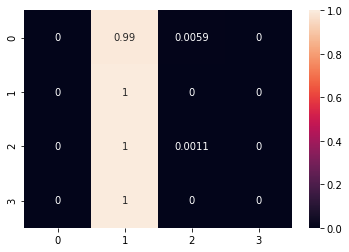

In [44]:
print(classification_report(test.label, y_3))

print("F1-score: {}\nAUC: {}\nAccuracy: {}".format(
    f1_score(test.label, y_3, average = "macro"),
    roc_auc_score(binarizer.fit_transform(y_test), pred_3, average = "macro", multi_class = "ovr"),
    accuracy_score(test.label, y_3)
))

sns.heatmap(
    confusion_matrix(test.label, y_3, normalize='true'),
    annot = True
)

# Modèle sans Stem-Lem avec sur-échantillonnage

## Entraînement

Sur-échantillonnage

In [45]:
ros = RandomOverSampler(
    sampling_strategy={
        0: 1746,
        1: 2707,
        2: 1746,
        3: 1746
    }
)
x_ros, y_ros = ros.fit_resample(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [46]:
with strategy.scope():
  model_4 = Camembert.from_pretrained(f"weights/{MODEL}")
  model_4.layers[0].trainable = False
  optimizer = tf.keras.optimizers.Adam(lr=1e-5)
  model_4.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  train_ros_dataset = (
      tf.data.Dataset
      .from_tensor_slices((x_ros, y_ros))
      .repeat()
      .shuffle(BUFFER)
      .batch(BATCH_D)
      .prefetch(AUTO)
  )

epochs_done = 0
history = model_4.fit(
  train_ros_dataset,
  epochs = 200,
  steps_per_epoch = int(np.ceil(x_ros.shape[0]/BATCH_D)),
  callbacks = [early],
  validation_data = val_dataset,
  initial_epoch = epochs_done,
  workers = 8,
  use_multiprocessing = True
)

All model checkpoint layers were used when initializing Camembert.

All the layers of Camembert were initialized from the model checkpoint at weights/cam_base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use Camembert for predictions without further training.


Epoch 1/200
63/63 [==============================] - 26s 132ms/step - loss: 2.4046 - accuracy: 0.2219 - val_loss: 2.8758 - val_accuracy: 0.0117
Epoch 2/200
63/63 [==============================] - 3s 42ms/step - loss: 2.0928 - accuracy: 0.2163 - val_loss: 2.3917 - val_accuracy: 0.0117
Epoch 3/200
63/63 [==============================] - 3s 42ms/step - loss: 1.8293 - accuracy: 0.2261 - val_loss: 2.0349 - val_accuracy: 0.0117
Epoch 4/200
63/63 [==============================] - 3s 42ms/step - loss: 1.7163 - accuracy: 0.2121 - val_loss: 1.7747 - val_accuracy: 0.0117
Epoch 5/200
63/63 [==============================] - 3s 42ms/step - loss: 1.5968 - accuracy: 0.2357 - val_loss: 1.5943 - val_accuracy: 0.0125
Epoch 6/200
63/63 [==============================] - 3s 42ms/step - loss: 1.5567 - accuracy: 0.2327 - val_loss: 1.4787 - val_accuracy: 0.0266
Epoch 7/200
63/63 [==============================] - 3s 42ms/step - loss: 1.5251 - accuracy: 0.2506 - val_loss: 1.4126 - val_accuracy: 0.1969
Epoc

In [47]:
with strategy.scope():
  model_4.layers[0].trainable = True
  optimizer = tf.keras.optimizers.Adam(lr=1e-7)
  model.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

epochs_done = 20
history = model_4.fit(
  train_ros_dataset,
  epochs = 200,
  steps_per_epoch = int(np.ceil(x_ros.shape[0]/BATCH_D)),
  callbacks = [early],
  validation_data = val_dataset,
  initial_epoch = epochs_done,
  workers = 8,
  use_multiprocessing = True
)

Epoch 21/200
63/63 [==============================] - 3s 42ms/step - loss: 1.5049 - accuracy: 0.2728 - val_loss: 1.2827 - val_accuracy: 0.5273
Epoch 22/200
63/63 [==============================] - 3s 44ms/step - loss: 1.4901 - accuracy: 0.2805 - val_loss: 1.2773 - val_accuracy: 0.5273
Epoch 23/200
63/63 [==============================] - 3s 43ms/step - loss: 1.4852 - accuracy: 0.2879 - val_loss: 1.2680 - val_accuracy: 0.5273
Epoch 24/200
63/63 [==============================] - 3s 43ms/step - loss: 1.4937 - accuracy: 0.2780 - val_loss: 1.2711 - val_accuracy: 0.5273
Epoch 25/200
63/63 [==============================] - 3s 45ms/step - loss: 1.4969 - accuracy: 0.2755 - val_loss: 1.2646 - val_accuracy: 0.5273
Epoch 26/200
63/63 [==============================] - 3s 42ms/step - loss: 1.5050 - accuracy: 0.2769 - val_loss: 1.2746 - val_accuracy: 0.5273
Epoch 27/200
63/63 [==============================] - 3s 42ms/step - loss: 1.4873 - accuracy: 0.2878 - val_loss: 1.2759 - val_accuracy: 0.5273

## Evaluation

In [48]:
counts = np.sort(np.unique(np.concatenate([y_train, y_val]), return_counts = True)[1])
ros = RandomOverSampler(sampling_strategy={
    0: counts[-2],
    1: counts[-1],
    2: counts[-2],
    3: counts[-2]
})

x_ros, y_ros = ros.fit_resample(
    tf.concat([x_train, x_val], axis = 0),
    np.concatenate([y_train, y_val])
)

train_ros_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_ros, y_ros))
    .repeat()
    .shuffle(BUFFER)
    .batch(BATCH_D)
    .prefetch(AUTO)
)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [52]:
del final_model_4
del final_model_1
del final_model_2
del final_model_3
del model
del model_2
del model_3
del model_4
gc.collect()

2394152

In [53]:
with strategy.scope():
  final_model_4 = Camembert.from_pretrained(f"weights/{MODEL}")
  final_model_4.layers[0].trainable = False
  optimizer = tf.keras.optimizers.Adam(lr=1e-5)
  final_model_4.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

epochs_done = 0
history = final_model_4.fit(
  train_ros_dataset,
  epochs = 18,
  steps_per_epoch = int(np.ceil(x_ros.shape[0]/BATCH_D)),
  initial_epoch = epochs_done,
  workers = 8, verbose = 0,
  use_multiprocessing = True
)

with strategy.scope():
  final_model_4.layers[0].trainable = True
  optimizer = tf.keras.optimizers.Adam(lr=1e-7)
  final_model_4.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

epochs_done = 18
history = final_model_4.fit(
  train_ros_dataset,
  epochs = epochs_done + 1,
  steps_per_epoch = int(np.ceil(x_ros.shape[0]/BATCH_D)),
  initial_epoch = epochs_done,
  workers = 8, verbose = 0,
  use_multiprocessing = True
)

All model checkpoint layers were used when initializing Camembert.

All the layers of Camembert were initialized from the model checkpoint at weights/cam_base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use Camembert for predictions without further training.


              precision    recall  f1-score   support

     EMOTION       0.00      0.00      0.00       337
 INFORMATION       0.45      1.00      0.62      1473
     OPINION       0.00      0.00      0.00       950
   SENTIMENT       0.00      0.00      0.00       523

    accuracy                           0.45      3283
   macro avg       0.11      0.25      0.15      3283
weighted avg       0.20      0.45      0.28      3283

F1-score: 0.15468156895824547
AUC: 0.53759796720932
Accuracy: 0.4468473956746878


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


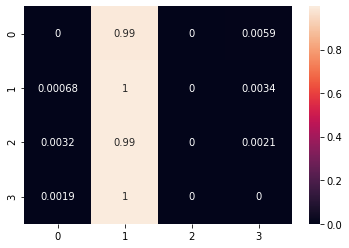

In [54]:
pred_4 = final_model_4.predict(x_test)
y_4 = encoder.inverse_transform(np.argmax(pred_4, axis = 1))

print(classification_report(test.label, y_4))

print("F1-score: {}\nAUC: {}\nAccuracy: {}".format(
    f1_score(test.label, y_4, average = "macro"),
    roc_auc_score(binarizer.fit_transform(y_test), pred_4, average = "macro", multi_class = "ovr"),
    accuracy_score(test.label, y_4)
))

sns.heatmap(
    confusion_matrix(test.label, y_4, normalize='true'),
    annot = True
)